In [ ]:
#1. import libraries
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, GRU

In [ ]:
# 2. Read csv file
df = pd.read_csv('BID.csv')
df =df.reset_index()['Price']
df

0       11054.8
1       10574.2
2        9973.4
3       10213.7
4       10153.6
         ...   
2466    41500.0
2467    41000.0
2468    41200.0
2469    41300.0
2470    41800.0
Name: Price, Length: 2471, dtype: float64

In [ ]:
# 3. Scale data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
# 4.Train 7 Test 3
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [ ]:
# 5.Create Dataset
import numpy
# convert an array of values into a dataset matrix, split data into time column
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42)


#colsample_bynode: Tỉ lệ các đặc trưng được chọn ngẫu nhiên cho mỗi phân nhánh trong một cây,
#gamma: Mức giảm thiểu tổn thất tối thiểu cần thiết để thực hiện một phân vùng khác trên một nút lá.
#importance_type='gain': Xác định phương pháp được sử dụng để tính độ quan trọng của đặc trưng
#learning_rate: Kích thước bước co thu hẹp được sử dụng để ngăn chặn quá mức.
#max_delta_step: Bước delta tối đa được phép cho mỗi ước lượng trọng số của cây
#max_depth: Độ sâu tối đa của một cây. Nó kiểm soát độ sâu tối đa của các cây cá thể trong tập hợp
#n_estimators: Số vòng tăng cường (cây) sẽ được chạy. Tham số này kiểm soát số cây được thêm vào mô hình
#random_state: Giống cho bộ tạo số ngẫu nhiên, đảm bảo khả năng tái tạo của kết quả

In [ ]:
# 9. Fit model, train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.01, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=1, nthread=None, num_parallel_tree=None, ...)

In [ ]:
# 10. Predcit data
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred.reshape(-1,1))

In [ ]:
train_size1 = int(0.7 * len(df))
test_size1 = int(0.3 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]

# re make predictions on the testing set
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [ ]:
# 12. accurate algorithms
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Testing RMSE:', round(test_rmse, 3))

#MAPE
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Testing MAPE:', round(test_mape, 3))

#MAE
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Testing MAE:', round(test_mae, 3))

msle = np.mean((np.log1p(y_pred) - np.log1p(y_test1))**2)
print('MSLE:', round(msle, 3))

Testing RMSE: 6409.74
Testing MAPE: 13.595
Testing MAE: 5323.12
MSLE: 0.028


In [ ]:
#13
# next 30 days
pred_next = np.array([])

# change data input
y_predict_to_next = scaler.fit_transform(np.array(y_test1[-time_step:].reshape(1, -1)).reshape(-1, 1))

for i in range(30):
    print(y_predict_to_next)
    y_pred_next = model.predict(y_predict_to_next.reshape(1, -1))
    y_predict_to_next = np.append(y_predict_to_next, y_pred_next[0])[1:]

    pred_next = np.append(pred_next, y_pred_next[0])

# nghich dao
next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1, 1)))


[[0.91219512]
 [1.        ]
 [0.94634146]
 [0.93170732]
 [0.97560976]
 [0.95609756]
 [0.91219512]
 [0.74634146]
 [0.76585366]
 [0.85365854]
 [0.79512195]
 [0.84390244]
 [0.80487805]
 [0.52195122]
 [0.65853659]
 [0.67804878]
 [0.66829268]
 [0.67804878]
 [0.6195122 ]
 [0.63902439]
 [0.67804878]
 [0.71707317]
 [0.7902439 ]
 [0.84390244]
 [0.82439024]
 [0.82926829]
 [0.79512195]
 [0.74634146]
 [0.79512195]
 [0.79512195]
 [0.77073171]
 [0.77560976]
 [0.67317073]
 [0.6195122 ]
 [0.66829268]
 [0.6195122 ]
 [0.70243902]
 [0.6097561 ]
 [0.53658537]
 [0.54146341]
 [0.53658537]
 [0.53658537]
 [0.49756098]
 [0.26341463]
 [0.35609756]
 [0.26829268]
 [0.32682927]
 [0.30243902]
 [0.31219512]
 [0.30731707]
 [0.32195122]
 [0.35609756]
 [0.27317073]
 [0.23902439]
 [0.11219512]
 [0.13170732]
 [0.16097561]
 [0.14146341]
 [0.23902439]
 [0.18536585]
 [0.16585366]
 [0.30731707]
 [0.2097561 ]
 [0.13170732]
 [0.11219512]
 [0.27317073]
 [0.25853659]
 [0.28780488]
 [0.28780488]
 [0.39512195]
 [0.3902439 ]
 [0.32

In [ ]:
next30days_predict_inverse

0
0   41266.507196
1   41240.994482
2   41254.081896
3   41280.637956
4   41280.637956
5   41280.637956
6   41296.537714
7   41296.537714
8   41296.537714
9   41296.537714
10  41296.537714
11  41296.537714
12  41296.537714
13  41296.537714
14  41296.537714
15  41281.927666
16  41281.927666
17  41281.927666
18  41281.927666
19  41281.927666
20  41281.927666
21  41255.371606
22  41255.371606
23  41269.981655
24  41269.981655
25  41269.981655
26  41269.981655
27  41269.981655
28  41269.981655
29  41281.927666

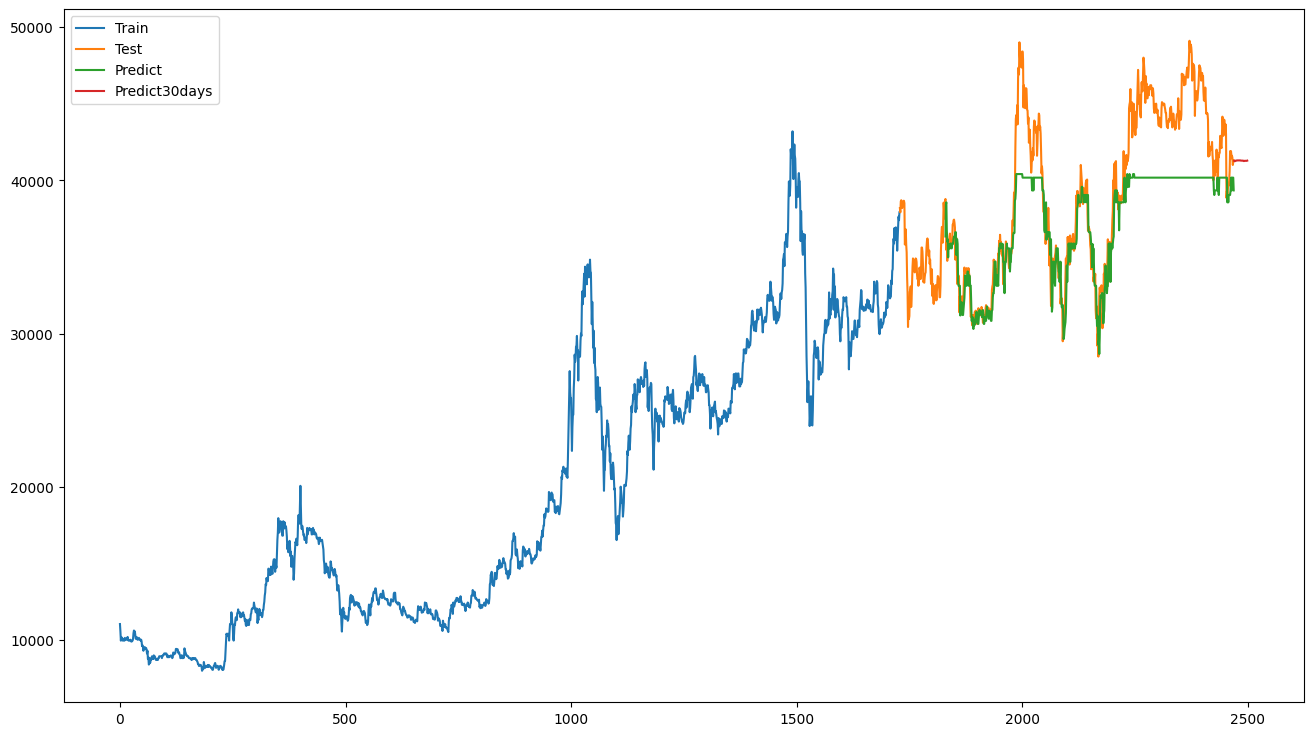

In [ ]:
# 14.plots
plt.figure(figsize =(16, 9))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data1)
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,next30days_predict_inverse)
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [ ]:
train_data
